In [216]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from itertools import product
from nltk import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [217]:
# Read the training data
df_train = pd.read_csv('./Data/BBC News Train.csv')
# Read the test data
df_test = pd.read_csv('./Data/BBC News Test.csv')

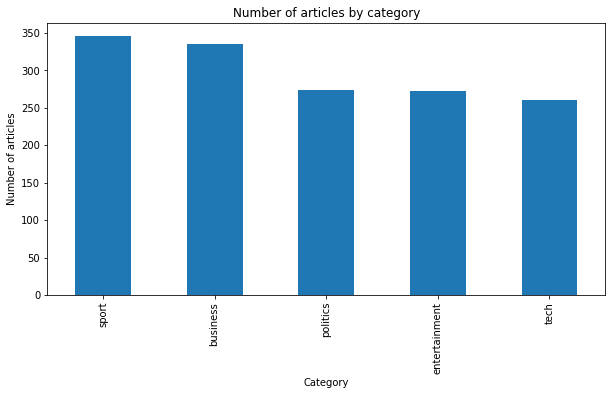

In [218]:
# display by category
df_train['Category'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.title('Number of articles by category')
plt.xlabel('Category')
plt.ylabel('Number of articles')
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


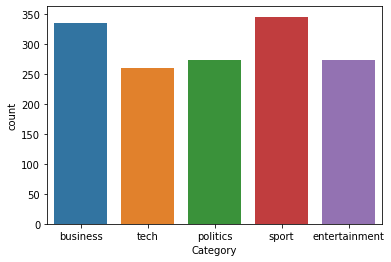

In [219]:
# Plot the distribution of the target variable
sns.countplot(df_train['Category'])
plt.show()


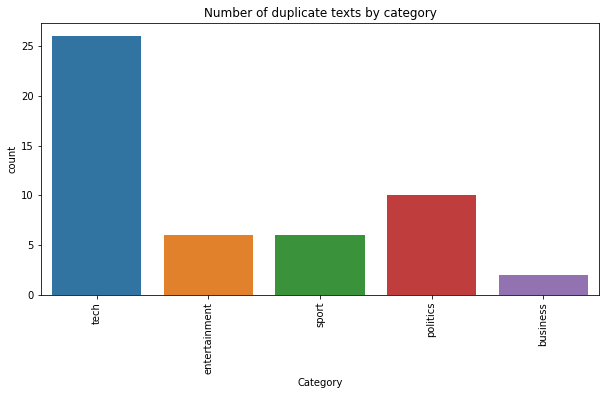

Total number of duplicate texts:  50


In [220]:

# Get the duplicate texts
dup_text = df_train[df_train.duplicated(subset=['Text'], keep=False)].sort_values(by='Text').head(50)
# Plot the number of duplicate text by category
plt.figure(figsize=(10, 5))
# Title of the plot
plt.title('Number of duplicate texts by category')
sns.countplot(x='Category', data=dup_text)
plt.xticks(rotation=90)
plt.show()

# Total number of duplicate texts
print('Total number of duplicate texts: ', len(dup_text))


In [221]:
# Remove the duplicate texts
df_train.drop_duplicates(subset=['Text'], keep='first', inplace=True)
# Reset the index
df_train.reset_index(drop=True, inplace=True)

# Print the shape of the training data
print('Shape of the training data: ', df_train.shape)

Shape of the training data:  (1440, 3)


In [222]:
#Manually encode the target variable
df_train['Category'] = df_train['Category'].map({'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4})
# Print the first 3 rows of the training data
df_train.head(5)


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,0
1,154,german business confidence slides german busin...,0
2,1101,bbc poll indicates economic gloom citizens in ...,0
3,1976,lifestyle governs mobile choice faster bett...,4
4,917,enron bosses in $168m payout eighteen former e...,0


In [223]:
# Write function to clean the text
import re
import nltk
from nltk.corpus import stopwords

stopwords_en = set(stopwords.words('english'))

def clean_text(text):
    
    # Remove new line and Carriage returns
    text = re.sub(r'\n', ' ', text)
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
    # Remove all numberic and special characters
    #text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stopwords_en])
    return text

In [224]:
# Clean the text
df_train['Text'] = df_train['Text'].apply(clean_text)
df_test['Text'] = df_test['Text'].apply(clean_text)

In [225]:
df_train

,ArticleId,Text,Category
0,1833,worldcom exboss launches defence lawyers defen...,0
1,154,german business confidence slides german busin...,0
2,1101,bbc poll indicates economic gloom citizens maj...,0
3,1976,lifestyle governs mobile choice faster better ...,4
4,917,enron bosses 168m payout eighteen former enron...,0
...,...,...,...
1435,857,double eviction big brother model caprice holb...,1
1436,325,dj double act revamp chart show dj duo jk joel...,1
1437,1590,weak dollar hits reuters revenues media group ...,0
1438,1587,apple ipod family expands market apple expande...,4


In [226]:
X_train = df_train['Text']
y_train = df_train['Category']
X_test = df_test['Text']

In [227]:
print('X_train shape ', X_train.shape)
print('y_train shape ', y_train.shape)
print('X_test shape ', X_test.shape)



X_train shape  (1440,)
y_train shape  (1440,)
X_test shape  (735,)


In [228]:
#vectorizer = TfidfVectorizer(encoding = 'utf-8', ngram_range = (1,2),stop_words= None,lowercase = False, max_df = 0.95, min_df = 10,norm = 'l2',sublinear_tf = True)

vectorizer = TfidfVectorizer(encoding = 'utf-8', ngram_range = (1,2),stop_words= None,lowercase = False, max_df = 0.95, 
                            min_df = 10,norm = 'l2',sublinear_tf = True)

X = vectorizer.fit_transform(X_train).toarray()
tokens = vectorizer.get_feature_names_out()
print('Number of tokens: ', len(tokens))
print('Number of documents: ', len(X_train))
print('Number of features: ', len(X[0]))

Number of tokens:  4830
Number of documents:  1440
Number of features:  4830


In [230]:
print("Weights given to words by idf:")
pd.DataFrame(vectorizer.idf_, vectorizer.get_feature_names_out(), columns=["idf_weights"]).sort_values(by="idf_weights")

Weights given to words by idf:


,idf_weights
said,1.160765
also,1.597269
would,1.662397
one,1.783888
new,1.805394
...,...
millennium,5.875197
director general,5.875197
directing,5.875197
rushed,5.875197


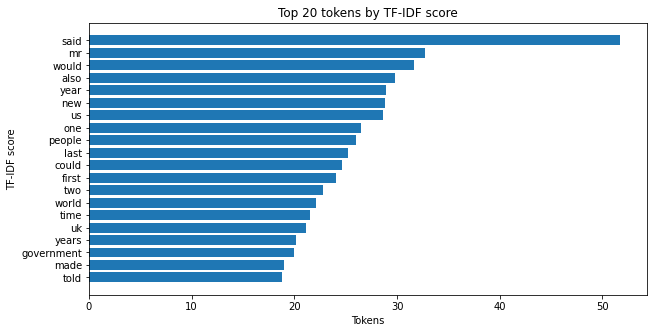

In [231]:
# Plot top 20 tokens by TF-IDF score in descending order with tokens on the x-axis and TF-IDF score on the y-axis
plt.figure(figsize=(10, 5))
plt.title('Top 20 tokens by TF-IDF score')
plt.xlabel('Tokens')
plt.ylabel('TF-IDF score')
plt.barh(range(20), np.sort(X.sum(axis=0))[-20:], align='center')
plt.yticks(range(20), np.array(tokens)[np.argsort(X.sum(axis=0))[-20:]])
plt.show()

In [232]:
# Try with parameter values given in sklearn eample
random_state=1
n_components = 5
beta_loss="frobenius"
alpha_W=0.00005
alpha_H=0.00005
l1_ratio=1

nmf = NMF(n_components = 5, random_state = 42, solver = "mu", beta_loss = "kullback-leibler", max_iter= 1000)
model = nmf.fit(X)
W = nmf.fit_transform(X)
H = nmf.components_

In [233]:
# Display the top 10 words for each topic
for topic_idx, topic in enumerate(H):
    print("Topic %d:" % (topic_idx))
    print(" ".join([tokens[i]
                    for i in topic.argsort()[:-10 - 1:-1]]))

Topic 0:
said us company firm market year growth shares economy 2004
Topic 1:
game win england cup said club players side team season
Topic 2:
mr labour government election blair would said party minister prime
Topic 3:
film awards best star show award actor music films band
Topic 4:
people technology users use software mobile said online internet phone


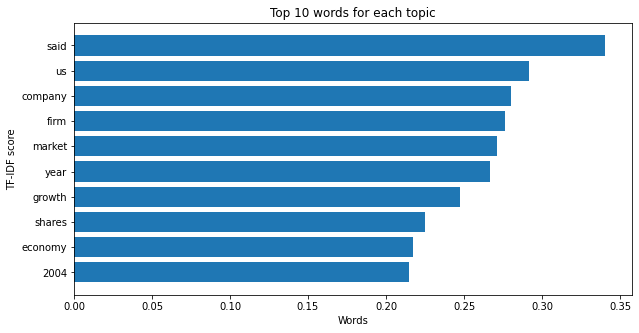

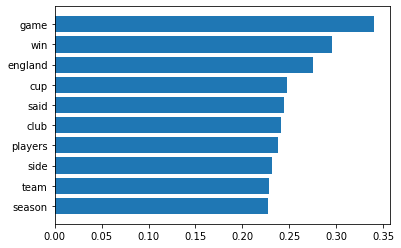

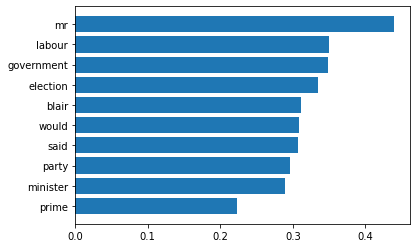

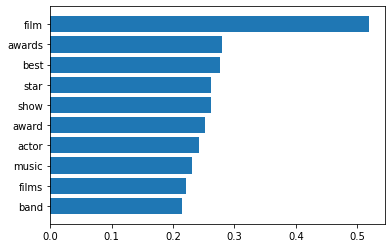

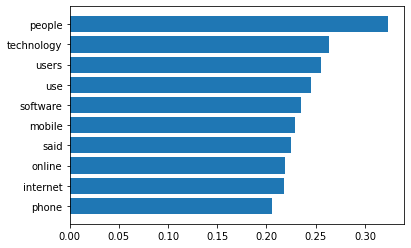

In [234]:
# Plot the top 10 words for each topic also dispay topic names
plt.figure(figsize=(10, 5))
plt.title('Top 10 words for each topic')
plt.xlabel('Words')
plt.ylabel('TF-IDF score')
for topic_idx, topic in enumerate(H):
    plt.barh(range(10), np.sort(topic)[-10:], align='center')
    plt.yticks(range(10), np.array(tokens)[np.argsort(topic)[-10:]])
    plt.show()
    




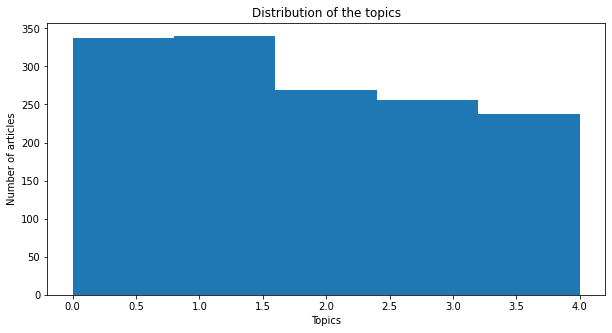

In [235]:
# Plot the distribution of the topics
plt.figure(figsize=(10, 5))
plt.title('Distribution of the topics')
plt.xlabel('Topics')
plt.ylabel('Number of articles')
plt.hist(np.argmax(W, axis=1), bins=5)
plt.show()


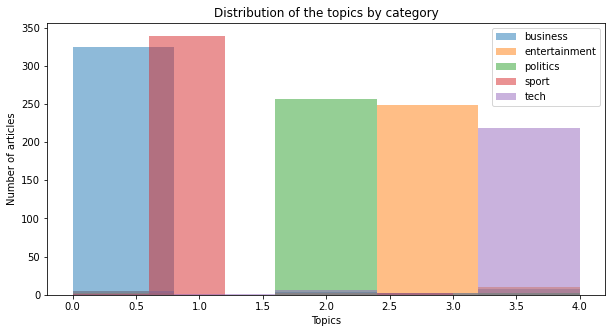

In [236]:
# Plot the distribution of the topics by category
plt.figure(figsize=(10, 5))
plt.title('Distribution of the topics by category')
plt.xlabel('Topics')
plt.ylabel('Number of articles')
plt.hist(np.argmax(W, axis=1)[y_train == 0], bins=5, alpha=0.5, label='business')
plt.hist(np.argmax(W, axis=1)[y_train == 1], bins=5, alpha=0.5, label='entertainment')
plt.hist(np.argmax(W, axis=1)[y_train == 2], bins=5, alpha=0.5, label='politics')
plt.hist(np.argmax(W, axis=1)[y_train == 3], bins=5, alpha=0.5, label='sport')
plt.hist(np.argmax(W, axis=1)[y_train == 4], bins=5, alpha=0.5, label='tech')

plt.legend()
plt.show()



In [237]:
accuracy_score(y_train , pd.DataFrame(np.argmax(W, axis=1)[:]))

0.5569444444444445

In [238]:
# Find the optimal permutation based on training data
# Get the permutation matrix
perm = np.array([np.argmax(np.bincount(y_train[np.argmax(W, axis=1) == i])) for i in range(n_components)])
# Permute the rows of W
W_perm = W[:, perm]
# Permute the rows of H
H_perm = nmf.components_[perm, :]

# Display accuracy score    
print('Accuracy score: ', accuracy_score(y_train, np.argmax(W_perm, axis=1)))

perm

Accuracy score:  0.9638888888888889


array([0, 3, 2, 1, 4])

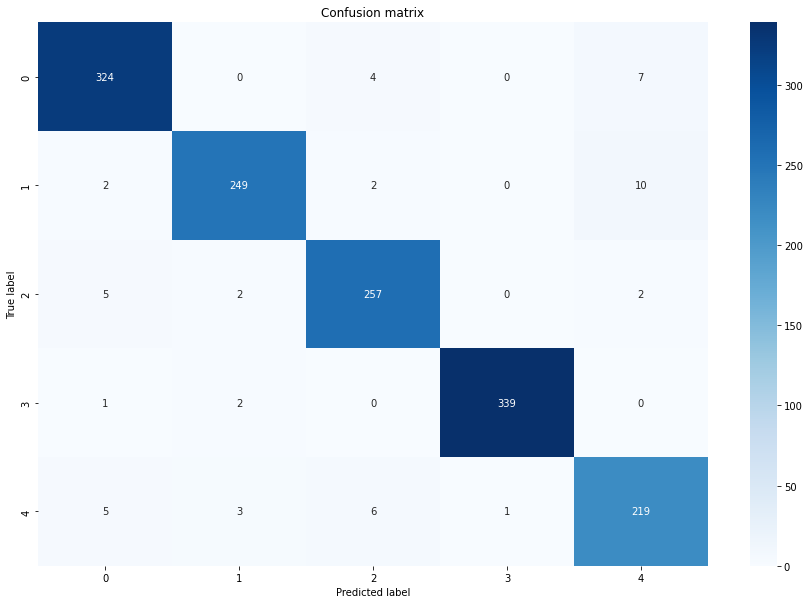

In [239]:
# Permute the rows of the confusion matrix
confusion_matrix_perm = confusion_matrix(y_train, np.argmax(W_perm, axis=1))
# Plot the confusion matrix
plt.figure(figsize=(15, 10))
sns.heatmap(confusion_matrix_perm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [240]:
# Create a dataframe with articleid, text, category and predicted category
df_pred = pd.DataFrame({'ArticleId': df_train['ArticleId'], 'Text': df_train['Text'], 'Category': df_train['Category'], 'PredictedCategory': np.argmax(W_perm, axis=1)})
# Reverse the mapping of the target variable
df_pred['Category'] = df_pred['Category'].map({0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'})
df_pred['PredictedCategory'] = df_pred['PredictedCategory'].map({0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'})
# Print the first 15 rows of the dataframe
df_pred.head(15)

,ArticleId,Text,Category,PredictedCategory
0,1833,worldcom exboss launches defence lawyers defen...,business,business
1,154,german business confidence slides german busin...,business,business
2,1101,bbc poll indicates economic gloom citizens maj...,business,business
3,1976,lifestyle governs mobile choice faster better ...,tech,tech
4,917,enron bosses 168m payout eighteen former enron...,business,business
5,1582,howard truanted play snooker conservative lead...,politics,politics
6,651,wales silent grand slam talk rhys williams say...,sport,sport
7,1797,french honour director parker british film dir...,entertainment,entertainment
8,2034,car giant hit mercedes slump slump profitabili...,business,business
9,1866,fockers fuel festive film chart comedy meet fo...,entertainment,entertainment


In [241]:

X_ = vectorizer.fit_transform(df_test['Text']).toarray()
y_hat = nmf.fit_transform(X_)
#index with highest probability is our predicted class
y_hat = np.argmax(y_hat, axis=1)

# create dataframe
y_hat = pd.DataFrame(y_hat)

# assign best labelorder to prediction
y_hat = y_hat.replace(np.unique(y_hat), [0, 3, 2, 1, 4])
y_hat.head()

,0
0,3
1,1
2,3
3,0
4,3


In [242]:
# Create a dataframe with articleid, text and predicted category
df_pred = pd.DataFrame({'ArticleId': df_test['ArticleId'],  'PredictedCategory': y_hat[0]})
# Reverse the mapping of the target variable
df_pred['Category'] = df_pred['PredictedCategory'].map({0: 'business', 1: 'entertainment', 2: 'politics', 3: 'sport', 4: 'tech'})
# Print the first 15 rows of the dataframe
df_pred.head(15)

# Remove predicted category column
df_pred.drop('PredictedCategory', axis=1, inplace=True)


In [243]:
# Print the first 15 rows of the dataframe
df_pred.head(15)


,ArticleId,Category
0,1018,sport
1,1319,entertainment
2,1138,sport
3,459,business
4,1020,sport
5,51,sport
6,2025,politics
7,1479,politics
8,27,tech
9,397,business


In [244]:
df_pred.shape
df_pred.to_csv('submission.csv', index=False)